<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/lstm_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM Multivariate Forecasting (Normalized)**

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

## **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate


from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense

print('Tensorflow version %s' % tf.__version__)

!pip install --quiet ipython-autotime pandas_gbq
%load_ext autotime

Tensorflow version 2.4.1
time: 2.44 ms (started: 2021-05-15 15:25:05 +00:00)


## **Preprocess Data**

#### **Import & Preprocess Data**

In [2]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('https://raw.githubusercontent.com/deltorobarba/repo/master/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
time: 776 ms (started: 2021-05-15 15:25:05 +00:00)


In [3]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/timeseries.csv'
data = pd.read_csv(url)
series = data[['date', 'price1', 'price2']].rename(columns={"price1": "google", "price2": "apple"}).set_index('date')
series.index = pd.to_datetime(series.index, utc=False)
dataset = series.copy()
dataset.head()

,google,apple
date,,
2010-02-01,265.51,280.42
2010-02-02,264.57,285.87
2010-02-03,269.40,279.49
2010-02-04,262.41,282.35
2010-02-05,264.65,284.06


time: 210 ms (started: 2021-05-15 15:25:05 +00:00)


#### **Visualize Dataset**

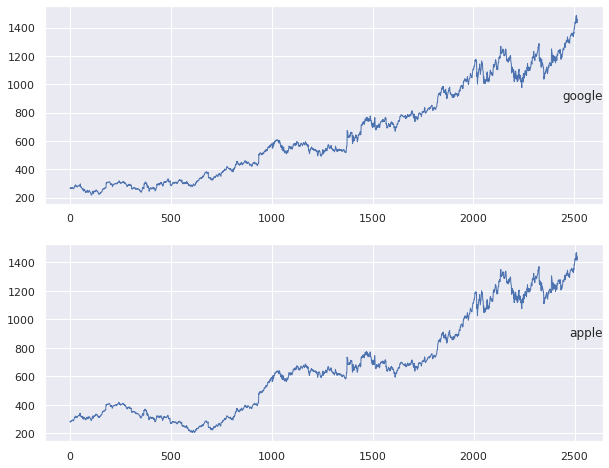

time: 314 ms (started: 2021-05-15 15:25:06 +00:00)


In [4]:
sns.set(rc={'figure.figsize':(10, 8), "lines.linewidth": 1.0})

# load dataset
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

#### **LSTM Preprocess Dataset**

In [5]:
windows = 3
features = 2

time: 1.18 ms (started: 2021-05-15 15:25:06 +00:00)


In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

time: 21.5 ms (started: 2021-05-15 15:25:06 +00:00)


In [7]:
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

time: 1.33 ms (started: 2021-05-15 15:25:06 +00:00)


In [8]:
# ensure all data is float
values = values.astype('float32')

time: 1.42 ms (started: 2021-05-15 15:25:06 +00:00)


In [9]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

time: 2.89 ms (started: 2021-05-15 15:25:06 +00:00)


In [10]:
# frame as supervised learning
reframed = series_to_supervised(scaled, windows, 1)

time: 15.5 ms (started: 2021-05-15 15:25:06 +00:00)


In [11]:
# Display data
reframed [:5]

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
3,0.038041,0.057941,0.037300,0.062260,0.041105,0.057204,0.035599,0.059470
4,0.037300,0.062260,0.041105,0.057204,0.035599,0.059470,0.037363,0.060825
5,0.041105,0.057204,0.035599,0.059470,0.037363,0.060825,0.038222,0.062482
6,0.035599,0.059470,0.037363,0.060825,0.038222,0.062482,0.039388,0.062181
7,0.037363,0.060825,0.038222,0.062482,0.039388,0.062181,0.038608,0.063441


time: 30.3 ms (started: 2021-05-15 15:25:06 +00:00)


In [12]:
# Show last column (to be removed)
num_rows, num_cols = reframed.shape
n = print (num_cols)
n

8
time: 3.67 ms (started: 2021-05-15 15:25:06 +00:00)


In [13]:
# drop columns we don't want to predict
n = 7 # number of last column (from above) minus 1 (the index column)
reframed.drop(reframed.columns[[n]], axis=1, inplace=True)
print(reframed.head())

   var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)
3   0.038041   0.057941   0.037300   0.062260   0.041105   0.057204  0.035599
4   0.037300   0.062260   0.041105   0.057204   0.035599   0.059470  0.037363
5   0.041105   0.057204   0.035599   0.059470   0.037363   0.060825  0.038222
6   0.035599   0.059470   0.037363   0.060825   0.038222   0.062482  0.039388
7   0.037363   0.060825   0.038222   0.062482   0.039388   0.062181  0.038608
time: 25.5 ms (started: 2021-05-15 15:25:06 +00:00)


#### **Shape for LSTM**

In [14]:
# how many rows (time stamps)?
reframed.shape[0]

2512

time: 3.79 ms (started: 2021-05-15 15:25:06 +00:00)


In [15]:
values = reframed.values
train_time = 2000
train = values[:train_time, :]
test = values[train_time:, :]

time: 4.83 ms (started: 2021-05-15 15:25:06 +00:00)


In [16]:
# split into input and outputs
n_obs = windows * features
train_X, train_y = train[:, :n_obs], train[:, -features]
test_X, test_y = test[:, :n_obs], test[:, -features]
print(train_X.shape, len(train_X), train_y.shape)

(2000, 6) 2000 (2000,)
time: 7.82 ms (started: 2021-05-15 15:25:06 +00:00)


In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], windows, features))
test_X = test_X.reshape((test_X.shape[0], windows, features))

time: 3.03 ms (started: 2021-05-15 15:25:06 +00:00)


In [18]:
print(test_X.shape, len(test_X), test_y.shape)

(512, 3, 2) 512 (512,)
time: 6.05 ms (started: 2021-05-15 15:25:06 +00:00)


In [19]:
test_X

array([[[0.6974705 , 0.72154284],
        [0.6997629 , 0.73530084],
        [0.7129499 , 0.73539597]],

       [[0.6997629 , 0.73530084],
        [0.7129499 , 0.73539597],
        [0.712556  , 0.7439867 ]],

       [[0.7129499 , 0.73539597],
        [0.712556  , 0.7439867 ],
        [0.72060686, 0.74274254]],

       ...,

       [[0.99822754, 0.99993664],
        [0.9994485 , 0.99999994],
        [1.        , 0.98370594]],

       [[0.9994485 , 0.99999994],
        [1.        , 0.98370594],
        [0.9842921 , 0.95722014]],

       [[1.        , 0.98370594],
        [0.9842921 , 0.95722014],
        [0.95844597, 0.97151715]]], dtype=float32)

time: 5.86 ms (started: 2021-05-15 15:25:06 +00:00)


## **Model Fitting & Forecasting**

#### **Create & Train Model**

In [20]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

time: 361 ms (started: 2021-05-15 15:25:06 +00:00)


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10600     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 11,121
Trainable params: 11,121
Non-trainable params: 0
_________________________________________________________________
time: 3.34 ms (started: 2021-05-15 15:25:07 +00:00)


In [22]:
# Fit model
history = model.fit(train_X, train_y, 
                    epochs=20, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=1, 
                    shuffle=False)

Epoch 1/20
28/28 [==============================] - 3s 32ms/step - loss: 0.0774 - val_loss: 0.0236
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 0.1364 - val_loss: 0.0655
Epoch 3/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0445 - val_loss: 0.0327
Epoch 4/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0384 - val_loss: 0.0516
Epoch 5/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0226 - val_loss: 0.0255
Epoch 6/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0227 - val_loss: 0.0155
Epoch 7/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0185 - val_loss: 0.0322
Epoch 8/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0234 - val_loss: 0.0127
Epoch 9/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0158 - val_loss: 0.0409
Epoch 10/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0195 - val_loss: 0.0269
Epoch 11/20
28/28 

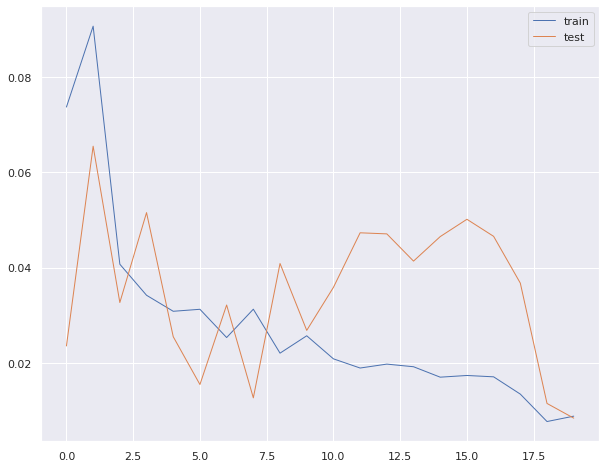

time: 309 ms (started: 2021-05-15 15:25:12 +00:00)


In [23]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### **Make a prediction**

In [24]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], windows*features))

time: 452 ms (started: 2021-05-15 15:25:13 +00:00)


In [25]:
# Shape: 6 windows (3 timesteps for 2 features)
test_X.shape[0], test_X.shape[1]

(512, 6)

time: 7.34 ms (started: 2021-05-15 15:25:13 +00:00)


In [26]:
test_X [0:5]

array([[0.6974705 , 0.72154284, 0.6997629 , 0.73530084, 0.7129499 ,
        0.73539597],
       [0.6997629 , 0.73530084, 0.7129499 , 0.73539597, 0.712556  ,
        0.7439867 ],
       [0.7129499 , 0.73539597, 0.712556  , 0.7439867 , 0.72060686,
        0.74274254],
       [0.712556  , 0.7439867 , 0.72060686, 0.74274254, 0.7188817 ,
        0.7493521 ],
       [0.72060686, 0.74274254, 0.7188817 , 0.7493521 , 0.7249632 ,
        0.7643464 ]], dtype=float32)

time: 10.2 ms (started: 2021-05-15 15:25:13 +00:00)


In [27]:
# Shape: one timestep forecasted for one feature
yhat.shape[0], yhat.shape[1]

(512, 1)

time: 8.34 ms (started: 2021-05-15 15:25:13 +00:00)


In [28]:
yhat [0:5]

array([[0.7276362 ],
       [0.7352899 ],
       [0.7374863 ],
       [0.74226683],
       [0.74877954]], dtype=float32)

time: 5.2 ms (started: 2021-05-15 15:25:13 +00:00)


## **Postprocess Data**

#### **Invert Scaling for Forecasted Test Data**

In [29]:
# remove all other features to align matrix structure
inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat [0:5]

array([[0.7276362 , 0.73539597],
       [0.7352899 , 0.7439867 ],
       [0.7374863 , 0.74274254],
       [0.74226683, 0.7493521 ],
       [0.74877954, 0.7643464 ]], dtype=float32)

time: 7.28 ms (started: 2021-05-15 15:25:13 +00:00)


In [30]:
inv_yhat.shape[0], inv_yhat.shape[1]

(512, 2)

time: 5.78 ms (started: 2021-05-15 15:25:13 +00:00)


In [31]:
inv_yhat = scaler.inverse_transform(inv_yhat)[:, [1]]
inv_yhat [0:5]

array([[1135.24],
       [1146.08],
       [1144.51],
       [1152.85],
       [1171.77]], dtype=float32)

time: 9.15 ms (started: 2021-05-15 15:25:13 +00:00)


In [32]:
inv_yhat = inv_yhat[:,0]

time: 1.54 ms (started: 2021-05-15 15:25:13 +00:00)


In [33]:
inv_yhat [0:5]

array([1135.24, 1146.08, 1144.51, 1152.85, 1171.77], dtype=float32)

time: 6.84 ms (started: 2021-05-15 15:25:13 +00:00)


#### **Invert Scaling for Actual Test Data**

In [34]:
# Display target data
test_y [0:5]

array([0.73539597, 0.7439867 , 0.74274254, 0.7493521 , 0.7643464 ],
      dtype=float32)

time: 5.64 ms (started: 2021-05-15 15:25:13 +00:00)


In [35]:
# Reshape target data to concatenate later
test_y = test_y.reshape((len(test_y), 1))
test_y [0:5]

array([[0.73539597],
       [0.7439867 ],
       [0.74274254],
       [0.7493521 ],
       [0.7643464 ]], dtype=float32)

time: 7.12 ms (started: 2021-05-15 15:25:13 +00:00)


In [36]:
# Display input data
test_X [0:5]

array([[0.6974705 , 0.72154284, 0.6997629 , 0.73530084, 0.7129499 ,
        0.73539597],
       [0.6997629 , 0.73530084, 0.7129499 , 0.73539597, 0.712556  ,
        0.7439867 ],
       [0.7129499 , 0.73539597, 0.712556  , 0.7439867 , 0.72060686,
        0.74274254],
       [0.712556  , 0.7439867 , 0.72060686, 0.74274254, 0.7188817 ,
        0.7493521 ],
       [0.72060686, 0.74274254, 0.7188817 , 0.7493521 , 0.7249632 ,
        0.7643464 ]], dtype=float32)

time: 4.32 ms (started: 2021-05-15 15:25:13 +00:00)


In [37]:
# Concatenate input & target data
### This is purely for demonstration !!

inv_y = concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y [0:5]

array([[0.73539597, 0.6974705 , 0.72154284, 0.6997629 , 0.73530084,
        0.7129499 , 0.73539597],
       [0.7439867 , 0.6997629 , 0.73530084, 0.7129499 , 0.73539597,
        0.712556  , 0.7439867 ],
       [0.74274254, 0.7129499 , 0.73539597, 0.712556  , 0.7439867 ,
        0.72060686, 0.74274254],
       [0.7493521 , 0.712556  , 0.7439867 , 0.72060686, 0.74274254,
        0.7188817 , 0.7493521 ],
       [0.7643464 , 0.72060686, 0.74274254, 0.7188817 , 0.7493521 ,
        0.7249632 , 0.7643464 ]], dtype=float32)

time: 8.95 ms (started: 2021-05-15 15:25:13 +00:00)


In [38]:
# Concatenate input & target data
inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y [0:5]

array([[0.73539597, 0.73539597],
       [0.7439867 , 0.7439867 ],
       [0.74274254, 0.74274254],
       [0.7493521 , 0.7493521 ],
       [0.7643464 , 0.7643464 ]], dtype=float32)

time: 6.09 ms (started: 2021-05-15 15:25:13 +00:00)


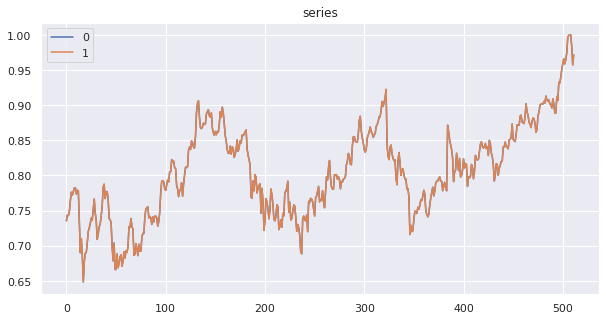

time: 460 ms (started: 2021-05-15 15:25:13 +00:00)


In [39]:
# testplot

df = pd.DataFrame(data=inv_y)
sns.set(rc={'figure.figsize':(10, 5)})
df.plot(title='series')

In [40]:
# Invert Scaling
inv_y = scaler.inverse_transform(inv_y)
inv_y [0:5]

array([[1150.7537, 1135.24  ],
       [1161.659 , 1146.08  ],
       [1160.0797, 1144.51  ],
       [1168.4701, 1152.85  ],
       [1187.5043, 1171.77  ]], dtype=float32)

time: 7.8 ms (started: 2021-05-15 15:25:14 +00:00)


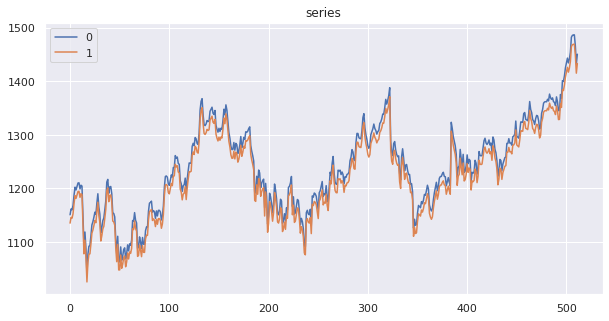

time: 385 ms (started: 2021-05-15 15:25:14 +00:00)


In [41]:
# testplot

df = pd.DataFrame(data=inv_y)
sns.set(rc={'figure.figsize':(10, 5)})
df.plot(title='series')

In [42]:
# Reshape again (transpose) and leave target data only (first column)
inv_y = inv_y[:,0]
inv_y [0:5]

array([1150.7537, 1161.659 , 1160.0797, 1168.4701, 1187.5043],
      dtype=float32)

time: 4.71 ms (started: 2021-05-15 15:25:14 +00:00)


## **Evaluate Model**

#### **Reshape Data and Plot**

In [43]:
df1 = inv_y.reshape((len(inv_y), 1))
# df1 [0:5]
df1 = pd.DataFrame(data=df1, columns=['Actual'])
df1.head()

,Actual
0,1150.753662
1,1161.659058
2,1160.079712
3,1168.470093
4,1187.504272


time: 19.1 ms (started: 2021-05-15 15:25:14 +00:00)


In [44]:
df2 = inv_yhat.reshape((len(inv_yhat), 1))
# df2 [0:5]
df2 = pd.DataFrame(data=df2, columns=['Forecast'])
df2.head()

,Forecast
0,1135.239990
1,1146.079956
2,1144.510010
3,1152.849976
4,1171.770020


time: 15.2 ms (started: 2021-05-15 15:25:14 +00:00)


In [45]:
def residuals(actual, forecast):
    # returns the difference between post and pre
    return actual - forecast

df = pd.concat([df1,df2], axis=1)
df['Residuals'] = residuals(df['Actual'], df['Forecast'])
df.head()

,Actual,Forecast,Residuals
0,1150.753662,1135.239990,15.513672
1,1161.659058,1146.079956,15.579102
2,1160.079712,1144.510010,15.569702
3,1168.470093,1152.849976,15.620117
4,1187.504272,1171.770020,15.734253


time: 22.9 ms (started: 2021-05-15 15:25:14 +00:00)


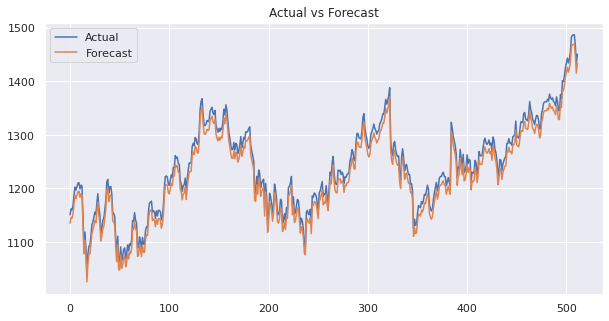

time: 371 ms (started: 2021-05-15 15:25:14 +00:00)


In [46]:
# Plot Actual vs Forecast Values
# df = pd.DataFrame(data=df)
sns.set(rc={'figure.figsize':(10, 5)})
df[['Actual', 'Forecast']].plot(title='Actual vs Forecast')

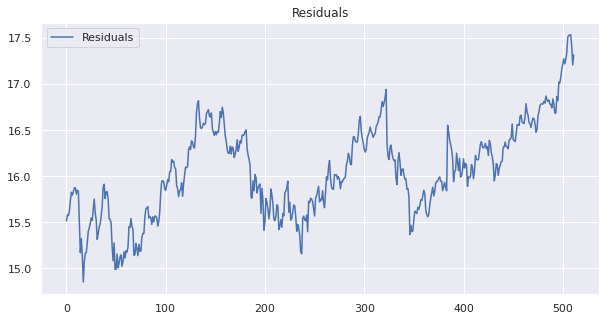

time: 376 ms (started: 2021-05-15 15:25:15 +00:00)


In [47]:
# Plot Residuals
sns.set(rc={'figure.figsize':(10, 5)})
df[['Residuals']].plot(title='Residuals')

#### **Calculate RMSE**

In [48]:
# inv_y : Test Actual Target Data
# inv_yhat : Test Forecasted Target Data
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 16.05
time: 2.89 ms (started: 2021-05-15 15:25:15 +00:00)


#### **Residuals**

In [49]:
# Get residuals (normalized)
residuals = (test_y[0] - yhat[:,0])
res = pd.DataFrame(data=residuals, columns=['residuals'])
res.head()

,residuals
0,0.007760
1,0.000106
2,-0.002090
3,-0.006871
4,-0.013384


time: 14.4 ms (started: 2021-05-15 15:25:15 +00:00)


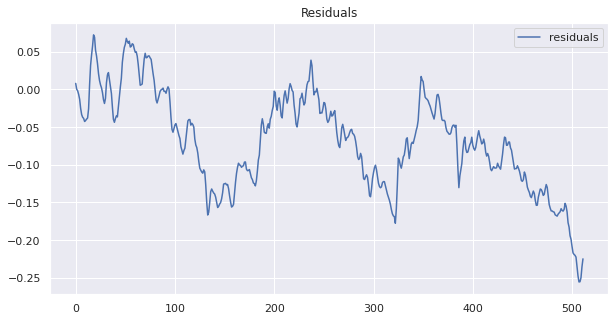

time: 379 ms (started: 2021-05-15 15:25:15 +00:00)


In [50]:
# Plot Residuals
sns.set(rc={'figure.figsize':(10, 5)})
res.plot(title='Residuals')

#### **Plot Results**

In [51]:
# Plot results

# shift train predictions for plotting
#trainPredictPlot = np.empty_like(dataset)
#trainPredictPlot[:, :] = np.nan
#trainPredictPlot[windows:len(yhat)+windows, :] = yhat

# shift test predictions for plotting
#testPredictPlot = np.empty_like(dataset)
#testPredictPlot[:, :] = np.nan
#testPredictPlot[len(test_X)+(windows*2)+1:len(dataset)-1, :] = test_X

# plot baseline and predictions
#sns.set(rc={'figure.figsize':(11, 5)})
#plt.plot(scaler.inverse_transform(dataset))
#plt.plot(dataset)
#plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
#plt.show()

time: 1.99 ms (started: 2021-05-15 15:25:16 +00:00)


# **LSTM Multivariate Forecasting (Unnormalized)**

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

## **Import Libraries**

In [52]:
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate


from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense

print('Tensorflow version %s' % tf.__version__)

!pip install --quiet ipython-autotime pandas_gbq
%load_ext autotime

Tensorflow version 2.4.1
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.85 s (started: 2021-05-15 15:25:16 +00:00)


## **Preprocess Data**

#### **Import & Preprocess Data**

In [53]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('https://raw.githubusercontent.com/deltorobarba/repo/master/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
time: 632 ms (started: 2021-05-15 15:25:18 +00:00)


In [54]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/timeseries.csv'
data = pd.read_csv(url)
series = data[['date', 'price1', 'price2']].rename(columns={"price1": "google", "price2": "apple"}).set_index('date')
series.index = pd.to_datetime(series.index, utc=False)
dataset = series.copy()
dataset.head()

,google,apple
date,,
2010-02-01,265.51,280.42
2010-02-02,264.57,285.87
2010-02-03,269.40,279.49
2010-02-04,262.41,282.35
2010-02-05,264.65,284.06


time: 63.1 ms (started: 2021-05-15 15:25:19 +00:00)


#### **Visualize Dataset**

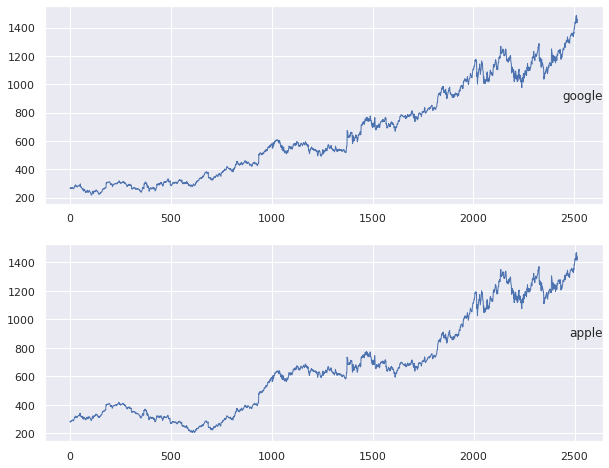

time: 296 ms (started: 2021-05-15 15:25:19 +00:00)


In [55]:
sns.set(rc={'figure.figsize':(10, 8), "lines.linewidth": 1.0})

# load dataset
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

#### **LSTM Preprocess Dataset**

In [56]:
windows = 3
features = 2

time: 1.2 ms (started: 2021-05-15 15:25:19 +00:00)


In [57]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

time: 20.5 ms (started: 2021-05-15 15:25:19 +00:00)


In [58]:
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

time: 1.5 ms (started: 2021-05-15 15:25:19 +00:00)


In [59]:
# ensure all data is float
values = values.astype('float32')

time: 1.39 ms (started: 2021-05-15 15:25:19 +00:00)


In [60]:
# remove this column if you normalize
scaled = values

time: 1.44 ms (started: 2021-05-15 15:25:19 +00:00)


In [61]:
# frame as supervised learning
reframed = series_to_supervised(scaled, windows, 1)

time: 9 ms (started: 2021-05-15 15:25:20 +00:00)


In [62]:
# Display data
reframed [:5]

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
3,265.510010,280.420013,264.570007,285.869995,269.399994,279.489990,262.410004,282.350006
4,264.570007,285.869995,269.399994,279.489990,262.410004,282.350006,264.649994,284.059998
5,269.399994,279.489990,262.410004,282.350006,264.649994,284.059998,265.739990,286.149994
6,262.410004,282.350006,264.649994,284.059998,265.739990,286.149994,267.220001,285.769989
7,264.649994,284.059998,265.739990,286.149994,267.220001,285.769989,266.230011,287.359985


time: 47.8 ms (started: 2021-05-15 15:25:20 +00:00)


In [63]:
# Show last column (to be removed)
num_rows, num_cols = reframed.shape
n = print (num_cols)
n

8
time: 11.4 ms (started: 2021-05-15 15:25:20 +00:00)


In [64]:
# drop columns we don't want to predict
n = 7 # number of last column (from above) minus 1 (the index column)
reframed.drop(reframed.columns[[n]], axis=1, inplace=True)
print(reframed.head())

    var1(t-3)   var2(t-3)   var1(t-2)  ...   var1(t-1)   var2(t-1)     var1(t)
3  265.510010  280.420013  264.570007  ...  269.399994  279.489990  262.410004
4  264.570007  285.869995  269.399994  ...  262.410004  282.350006  264.649994
5  269.399994  279.489990  262.410004  ...  264.649994  284.059998  265.739990
6  262.410004  282.350006  264.649994  ...  265.739990  286.149994  267.220001
7  264.649994  284.059998  265.739990  ...  267.220001  285.769989  266.230011

[5 rows x 7 columns]
time: 27.8 ms (started: 2021-05-15 15:25:20 +00:00)


#### **Shape for LSTM**

In [65]:
# how many rows (time stamps)?
reframed.shape[0]

2512

time: 4.95 ms (started: 2021-05-15 15:25:20 +00:00)


In [66]:
values = reframed.values
train_time = 2000
train = values[:train_time, :]
test = values[train_time:, :]

time: 3.73 ms (started: 2021-05-15 15:25:20 +00:00)


In [67]:
# split into input and outputs
n_obs = windows * features
train_X, train_y = train[:, :n_obs], train[:, -features]
test_X, test_y = test[:, :n_obs], test[:, -features]
print(train_X.shape, len(train_X), train_y.shape)

(2000, 6) 2000 (2000,)
time: 5.78 ms (started: 2021-05-15 15:25:20 +00:00)


In [68]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], windows, features))
test_X = test_X.reshape((test_X.shape[0], windows, features))

time: 4.78 ms (started: 2021-05-15 15:25:20 +00:00)


In [69]:
print(test_X.shape, len(test_X), test_y.shape)

(512, 3, 2) 512 (512,)
time: 3.17 ms (started: 2021-05-15 15:25:20 +00:00)


In [70]:
test_X

array([[[1102.61, 1117.76],
        [1105.52, 1135.12],
        [1122.26, 1135.24]],

       [[1105.52, 1135.12],
        [1122.26, 1135.24],
        [1121.76, 1146.08]],

       [[1122.26, 1135.24],
        [1121.76, 1146.08],
        [1131.98, 1144.51]],

       ...,

       [[1484.4 , 1469.04],
        [1485.95, 1469.12],
        [1486.65, 1448.56]],

       [[1485.95, 1469.12],
        [1486.65, 1448.56],
        [1466.71, 1415.14]],

       [[1486.65, 1448.56],
        [1466.71, 1415.14],
        [1433.9 , 1433.18]]], dtype=float32)

time: 6.14 ms (started: 2021-05-15 15:25:20 +00:00)


## **Model Fitting & Forecasting**

#### **Create & Train Model**

In [71]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

time: 311 ms (started: 2021-05-15 15:25:20 +00:00)


In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 11,121
Trainable params: 11,121
Non-trainable params: 0
_________________________________________________________________
time: 9.51 ms (started: 2021-05-15 15:25:20 +00:00)


In [73]:
# Fit model
history = model.fit(train_X, train_y, 
                    epochs=20, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=1, 
                    shuffle=False)

Epoch 1/20
28/28 [==============================] - 2s 22ms/step - loss: 388.7041 - val_loss: 1222.2377
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 386.7884 - val_loss: 1220.0491
Epoch 3/20
28/28 [==============================] - 0s 5ms/step - loss: 384.3222 - val_loss: 1217.0804
Epoch 4/20
28/28 [==============================] - 0s 5ms/step - loss: 381.3419 - val_loss: 1213.9192
Epoch 5/20
28/28 [==============================] - 0s 5ms/step - loss: 377.9174 - val_loss: 1209.9927
Epoch 6/20
28/28 [==============================] - 0s 5ms/step - loss: 373.7392 - val_loss: 1205.3843
Epoch 7/20
28/28 [==============================] - 0s 5ms/step - loss: 368.9452 - val_loss: 1199.8325
Epoch 8/20
28/28 [==============================] - 0s 5ms/step - loss: 363.2334 - val_loss: 1193.8235
Epoch 9/20
28/28 [==============================] - 0s 5ms/step - loss: 357.0614 - val_loss: 1187.1646
Epoch 10/20
28/28 [==============================] - 0s 5ms/step - loss:

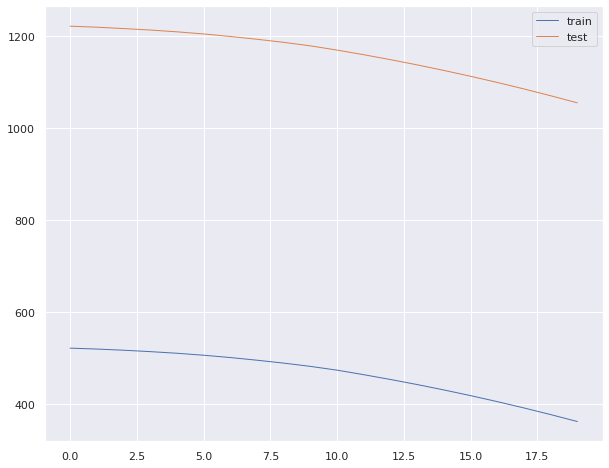

time: 568 ms (started: 2021-05-15 15:25:25 +00:00)


In [74]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### **Make a prediction**

In [75]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], windows*features))

time: 416 ms (started: 2021-05-15 15:25:26 +00:00)


In [76]:
# Shape: 6 windows (3 timesteps for 2 features)
test_X.shape[0], test_X.shape[1]

(512, 6)

time: 8.32 ms (started: 2021-05-15 15:25:26 +00:00)


In [77]:
test_X [0:5]

array([[1102.61, 1117.76, 1105.52, 1135.12, 1122.26, 1135.24],
       [1105.52, 1135.12, 1122.26, 1135.24, 1121.76, 1146.08],
       [1122.26, 1135.24, 1121.76, 1146.08, 1131.98, 1144.51],
       [1121.76, 1146.08, 1131.98, 1144.51, 1129.79, 1152.85],
       [1131.98, 1144.51, 1129.79, 1152.85, 1137.51, 1171.77]],
      dtype=float32)

time: 8.07 ms (started: 2021-05-15 15:25:26 +00:00)


In [78]:
# Shape: one timestep forecasted for one feature
yhat.shape[0], yhat.shape[1]

(512, 1)

time: 3.8 ms (started: 2021-05-15 15:25:26 +00:00)


In [79]:
yhat [0:5]

array([[167.6799],
       [167.6799],
       [167.6799],
       [167.6799],
       [167.6799]], dtype=float32)

time: 8.31 ms (started: 2021-05-15 15:25:26 +00:00)


#### **Evaluate on Unnormalized Data**

In [85]:
# Check shape of data
test_X.shape

(512, 6)

time: 3.86 ms (started: 2021-05-15 15:29:38 +00:00)


In [80]:
# remove unnecessary data
test_X_reshape = test_X[:, -1:]
test_X_reshape [0:5]

array([[1135.24],
       [1146.08],
       [1144.51],
       [1152.85],
       [1171.77]], dtype=float32)

time: 8.62 ms (started: 2021-05-15 15:25:26 +00:00)


In [81]:
# Concatenate series
df1 = pd.DataFrame(data=test_X_reshape, columns=['Actual'])
df2 = pd.DataFrame(data=yhat, columns=['Forecast'])

def residuals(Actual, Forecast):
    # returns the difference between post and pre
    return Actual - Forecast

df = pd.concat([df1,df2], axis=1)
df['Residuals'] = residuals(df['Actual'], df['Forecast'])
df.head()

,Actual,Forecast,Residuals
0,1135.239990,167.679901,967.560059
1,1146.079956,167.679901,978.400024
2,1144.510010,167.679901,976.830078
3,1152.849976,167.679901,985.170044
4,1171.770020,167.679901,1004.090088


time: 17.8 ms (started: 2021-05-15 15:25:26 +00:00)


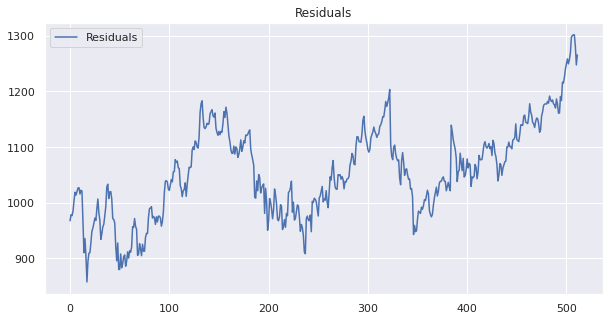

time: 377 ms (started: 2021-05-15 15:25:26 +00:00)


In [82]:
# Plot Residuals
sns.set(rc={'figure.figsize':(10, 5)})
df[['Residuals']].plot(title='Residuals')

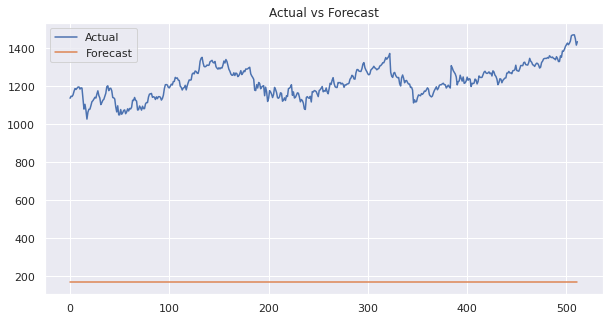

time: 389 ms (started: 2021-05-15 15:25:27 +00:00)


In [83]:
# Plot Actual vs Forecast Values
sns.set(rc={'figure.figsize':(10, 5)})
df[['Actual', 'Forecast']].plot(title='Actual vs Forecast')

In [84]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 16.05
time: 2.65 ms (started: 2021-05-15 15:25:27 +00:00)
